## Etsy Sale Analysis
Item includes: figures, women accessories, car accessories, home decorations etc

### 1. Load Data
#### 1.1 Pre-process Data
 - log on to Etsy account. Download etsy sale csv files from settings/options
 - combine sale data from all years
 - data filtering: remove unwanted listing id and data cleaning 
 - assign listing to a sub category/short name
  - merge data
 
#### 1.2 Key Fields:
     - Order Value  :   Book Value ( before tax, fee, shipping)
     - Order Revenue:   Gross Revenue = Order Value + Shipping 
     - Order Net    :   Net Revenue = Gross Revenue - Refund - Discount - Commission
     - Item Total   :   Price x Quantity

In [8]:
from IPython.display import display
import pandas as pd
import numpy as np
import itertools
import tabulate
import spacy
import calendar
import en_core_web_md
# import parameters
from util import * 

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [22]:
DATA_FIELDS = [
    'Sale Date', 'Ship State', 'Variations',
    'Order ID', 'Listing ID', 'Category',
    'Price','Quantity','Number of Items',  
    'Item Total', 'Gross Revenue',
    'Order Value','Order Revenue','Order Net', 
    ]

In [23]:
def print_heading(x):
    display ('-'*20+x+'-'*20)
    
def csv_reader(name, begin, end):
    files = ['%s%d.csv'%(name,i) for i in range(begin,end+1)]
    return pd.concat([pd.read_csv('data/'+csv, parse_dates=['Sale Date']) for  csv in files])

def assign_category(df):
    df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x) 
    mapper = df.sort_values('Sale Date').drop_duplicates(['Listing ID'], keep='last')[['Item Name','Listing ID']]
    mapper['Category'] = mapper['Listing ID'].map(CATEGORY_DICT)
    mask = lambda x: (mapper['Category'].isnull())&(mapper['Item Name'].str.contains(x))
    mapper.loc[mask('sock'),'Category'] = 'sock'
    mapper.loc[mask('figure'),'Category'] = 'figure'
    mapper.loc[mask('enamel pin'),'Category'] = 'pin'    
    return pd.Series(mapper['Category'].values,index=mapper['Listing ID']).to_dict()

def load_orders(begin=2021, end=2022):
    print_heading(' ORDER DETAILS ')      # ---------- ORDER   -------------
    orders = csv_reader(name='EtsySoldOrders', begin=begin, end=end)
    # redefine order net n order total
    orders['Order Net']     = orders.apply(lambda x: x['Adjusted Net Order Amount'] if x['Adjusted Net Order Amount']!=0 else x['Order Net'], axis=1)
    orders['Order Revenue'] = orders['Order Value'] + orders['Shipping']
    orders['Order Net']     = orders['Order Net'] - orders['Order Total']*0.05
    orders = orders[list(set(orders.columns) & set(DATA_FIELDS))]
    display(orders.head(3))
    
    print_heading(' ITEM DETAILS ')       # ---------- ORDER DETAILS   -------------
    items = csv_reader(name='EtsySoldOrderItems', begin=begin, end=end)

    drop_id = [1036136177,1031877031,1156104972] 
    items = items.loc[~items['Listing ID'].isin(drop_id)]         #drop unwanted listing id
    items['Category'] = items['Listing ID'].map(assign_category(items))
    items = items[list(set(items.columns) & set(DATA_FIELDS))]
    assert len(items[items['Category'].isnull()])== 0, 'Undefined listing, Edit mapper'
    display (items.head(3))

    cols_to_use = orders.columns.difference(items.columns).to_list()+['Order ID']
    df = pd.merge(
        items, orders[cols_to_use],
        how="left", on='Order ID',
        sort=True,indicator=False,
    )
    
    df['Shipping'] = (df['Category'].map(USPS_RATE).fillna(4))/df['Number of Items']*df['Quantity']+(df['Number of Items']-1)*0.25
    df['Listing Fee'] = 0.2
    df['Item Gross Revenue'] = df['Order Revenue']/df['Order Value']*(df['Item Total'])
    df['Item Net Revenue']   = df['Order Net']/df['Order Value']*(df['Item Total'])


    print_heading(' COMBINED ')
    display(df.head(3))

    df['Year']   = df['Sale Date'].dt.year
    df['Month']  = df['Sale Date'].dt.month
    df['Quarter']= 'Q'+df['Sale Date'].dt.quarter.astype(str)
    return df

    
orders = load_orders(begin=2021, end=2022)

'-------------------- ORDER DETAILS --------------------'

,Sale Date,Ship State,Order Net,Number of Items,Order Value,Order ID,Order Revenue
0,2021-12-31,MA,17.1210,1,18.99,2328983537,18.99
1,2021-12-30,CO,10.6975,1,11.99,2327911903,11.99
2,2021-12-29,OH,58.9390,4,71.96,2327234330,71.96


'-------------------- ITEM DETAILS --------------------'

,Price,Sale Date,Ship State,Category,Listing ID,Variations,Order ID,Quantity,Item Total
0,18.99,2021-12-31,MA,chair protector,953074300,"Color:Gray,Style:16 pc",2328983537,1,18.99
1,11.99,2021-12-30,CO,chair protector,953074300,"Color:Camouflage,Style:8pc",2327911903,1,11.99
2,18.99,2021-12-29,OH,chair protector,953074300,"Color:Orange,Style:16 pc",2327234330,1,18.99


'-------------------- COMBINED --------------------'

,Price,Sale Date,Ship State,Category,Listing ID,Variations,Order ID,Quantity,Item Total,Number of Items,Order Net,Order Revenue,Order Value,Shipping,Listing Fee,Item Gross Revenue,Item Net Revenue
0,6.99,2021-03-17,NY,chair protector,953074300,Color:Gray,1992574403,1,6.99,1,6.1295,6.99,6.99,4.0,0.2,6.99,6.1295
1,11.99,2021-03-26,MA,chair protector,953074300,"Color:Orange,Style:8pc",1997263668,1,11.99,1,10.7230,11.99,11.99,4.0,0.2,11.99,10.7230
2,6.99,2021-03-21,CA,chair protector,953074300,"Color:Orange,Style:4pc",1997751637,1,6.99,1,6.1320,6.99,6.99,4.0,0.2,6.99,6.1320


### 2.  Data Analytics
#### 2.1 Create Inventory Check System
 - Count number of items sold each month (by category)
 - Read total items purchased from data/COGS.csv file
 - Calculate inventory 
 - Set minimium threshold to 3 month's total sold - (restock process takes 1-3 months)
 - Compare inventory with threshold. 
         If inventory < threshold: mark status as 'LOW' 
 
#### 2.2 Calculate Profit
- Read cost of goods from data/COGS.csv file
- Calculate cost of goods
- Decide Shipping weights to estimate oversea shipping cost
        item purchased x weight per item/total weight shipped 
- Add oversea shipping to COGS
- Estimate domestic shipping (US first mail class)
- Estimate commission (Net Revenue is after discount, tax, commission)
- Calcualte profit
        profit = gross revenue - discount - shipping - tax - comission - COGS - other expense
        profit margin = profit / gross revenue x 100%



In [24]:
def calculate_cogs():
    df = pd.read_csv('data/COGS.csv').groupby(['Category']).sum().reset_index()
    df['USD']=df['RMB']/USDCHN
    df['w'] = df['Category'].map(WEIGHT)*df['Quantity']
    df['Weight'] = df['w']/(df['w']).sum()
    extra_cost = df.loc[df['w'].isnull(),'USD'].sum()
    df['COGS'] = df['USD']+extra_cost*df['Weight']
    return (df.loc[df['w'].notnull(),['Category','COGS','Quantity']]).set_index("Category")


def calculate_revenue():
    print_heading('Sale Summary Table')
    display(data.groupby(['Year']).agg({'Item Gross':'sum'}).rename(columns={'Item Gross':'Revenue'}))

    
def calculate_profit(df):
    print_heading(' PROFIT ')
    return pd.pivot_table(
                        df.groupby(['Category']).sum(), 
                        values = ['Item Gross Revenue','Item Net Revenue','Item Sold','Shipping','Listing Fee'], 
                        index = 'Category', 
        ).fillna(0)

def color_low_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val == 'Low' else 'black'
    return 'color: %s' % color


def sale_summary(data):
#   ############  Item sold   #############    
    'per item:  pieces in each variation'

    print_heading(' ITEM SOLD ')

    df = data.copy()
    mask = lambda x: (df['Category']== x )

    df['Per Item'] = df['Variations'].str.extract('(\d+)')
    df.loc[mask('figure'), 'Per Item']=(df.loc[mask('figure'), 'Price']/10).round(0)
    df.loc[mask('fold bag'), 'Per Item']=(df.loc[mask('fold bag'),'Price']/5).round(0)
    df.loc[mask('bracelet')&(df['Variations'].str.contains('pair')), 'Per Item'] = 2
    df['Per Item'] = df['Per Item'].fillna(1).astype(int)

    df['Item Sold'] = df['Quantity'].mul(df['Per Item'])
    df['Date'] = df['Sale Date'].dt.to_period('M')
    sold = pd.pivot_table(
                        df.groupby(['Date','Category']).sum(), 
                        values = 'Item Sold', 
                        index='Date', 
                        columns = 'Category', 
        ).fillna(0)
    display(sold.astype(int))
    ############  Inventory Check   #############    
    print_heading(' Inventory Check ')
    print ("Have at least 3 Month's supply ")
    cost = calculate_cogs()
    inventory = cost['Quantity']
    inv = pd.concat([ inventory.rename('No. Purchased'),sold.sum().rename('No. Sold')],axis=1)
    inv['Minimum Line']= sold.tail(3).sum()
    inv['Inventory'] = inv['No. Purchased'] - inv['No. Sold']
    inv = inv.astype(int)
    inv['Status'] = (inv['Inventory'] <= inv['Minimum Line']).map({True:'Low',False:'-'})
    inv = inv.T.style.applymap(color_low_red)
    display(inv)
    
#   ##############  Profit  #############    
# 
    pnl  = calculate_profit(df)
    rs = pd.concat([pnl,cost[['COGS']]],axis=1)
    rs['Item Profit'] = rs['Item Net Revenue']- rs['Listing Fee'] - rs['Shipping'] - rs['COGS']  
    rs['Profit Margin %'] = rs['Item Profit']/rs['Item Gross Revenue']*100
    display(rs.T.round(1))
    return 

   
sale_summary(orders)

'-------------------- ITEM SOLD --------------------'

Category,accessories,bracelet,car ornament,chair protector,figure,fold bag,pin,planter,sock,towel,wind chime
Date,,,,,,,,,,,
2021-03,0,0,0,21,0,0,0,0,0,0,0
2021-04,0,0,0,48,0,0,0,0,0,0,0
2021-05,0,0,1,152,2,0,0,0,0,0,0
2021-06,0,0,1,120,4,1,0,0,0,0,0
2021-07,0,0,9,184,32,1,0,0,3,0,0
2021-08,0,0,0,300,73,5,0,0,0,0,0
2021-09,0,0,5,224,23,7,0,0,0,0,0
2021-10,0,0,20,344,118,2,2,1,0,0,0
2021-11,1,0,21,452,91,6,7,1,7,0,0


'-------------------- Inventory Check --------------------'

Have at least 3 Month's supply 


Category,accessories,bracelet,car ornament,chair protector,figure,fold bag,pin,planter,sock,towel,wind chime
No. Purchased,84,51,640,5116,2234,115,509,12,123,6,43
No. Sold,3,4,217,3605,659,64,73,12,24,3,10
Minimum Line,0,4,86,916,210,29,36,2,2,2,2
Inventory,81,47,423,1511,1575,51,436,0,99,3,33
Status,-,-,-,-,-,-,-,Low,-,-,-


'-------------------- PROFIT --------------------'

Category,accessories,bracelet,car ornament,chair protector,figure,fold bag,pin,planter,sock,towel,wind chime
Item Gross Revenue,26.7,91.2,2366.2,4757.0,7692.2,448.1,603.5,684.9,210.3,72.0,190.9
Item Net Revenue,24.0,80.4,2117.9,4257.4,6902.0,401.8,538.3,595.7,189.3,65.3,172.5
Item Sold,3.0,4.0,217.0,3605.0,659.0,64.0,73.0,12.0,24.0,3.0,10.0
Listing Fee,0.6,0.8,36.6,62.0,86.0,8.4,10.0,2.4,3.8,0.6,1.8
Shipping,8.0,12.5,726.0,1141.0,1560.1,140.8,169.0,113.8,59.8,15.0,32.8
COGS,30.0,17.5,572.2,944.7,2800.3,148.1,164.7,132.3,159.2,70.8,101.0
Item Profit,-14.6,49.6,783.1,2109.7,2455.6,104.5,194.6,347.2,-33.5,-21.2,37.0
Profit Margin %,-54.9,54.4,33.1,44.3,31.9,23.3,32.2,50.7,-15.9,-29.4,19.4


### 3. Data Presentation
    present data using plotly
    
    data:
     - df_order: order details
     - df_item : item details in each order
 #### 3.1 Sale Growth
     - Quarterly (period='Quarter)
     - Monthly (period = 'Month')
 #### 3.2 top selling products
     - % of sale of each category 
 #### 3.3 customers geographic location
     - geo map


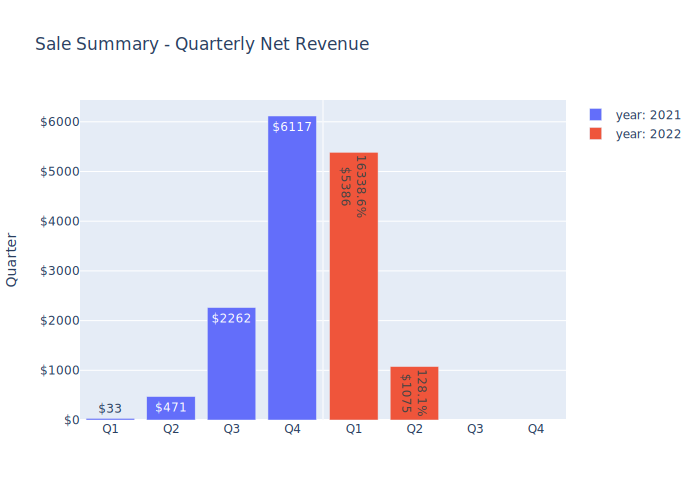

'-------------------- Sale breakdown in % --------------------'

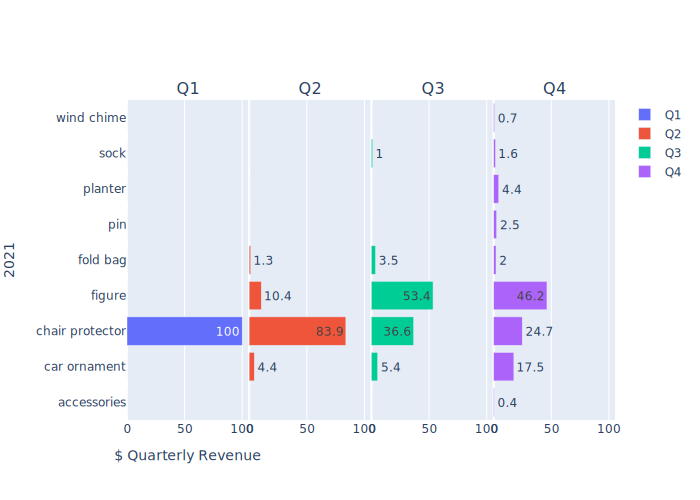

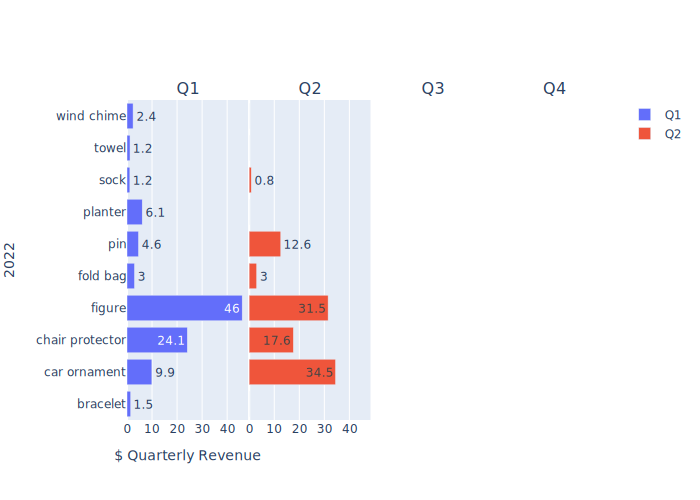

In [25]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

palette = cycle(px.colors.qualitative.Prism)

class Charts():
    def __init__(self, order):
        self.orders = order
        self.years  = order['Year'].unique()
        
    def revenue_report(self, period='Quarter'):
        #  ----------     quarterly sale summary    -------------
        
        grp = self.orders.groupby(['Year', period]).sum()
        df = pd.pivot_table(
                        grp, 
                        values = 'Item Net Revenue', 
                        index=[period], 
                        columns = 'Year', 
        )        
        pct = (df.pct_change(axis=1)*100).round(1).astype(str)+'%'
        pct = pct.replace(r'nan%|0.0%','',regex=True)+'<br>$'+\
        (df.round(0).astype('Int32')).astype(str).replace('<NA>','')
        df = df.rename(index=lambda x: calendar.month_abbr[x]) if period == 'Month' else df

        fig = make_subplots(
                                rows=1, 
                                cols=len(self.years), 
                                shared_yaxes='all', 
                                horizontal_spacing=0.002
                            )

        for i, yr in enumerate(self.years):
            fig.add_trace(
                go.Bar(x=df.index, y=df[yr],name='year: %d'%(yr),
                       text= pct[yr]),
                row=1, col=i+1
            )
        fig.update_layout(title_text="Sale Summary - %sly Net Revenue"%(period), yaxis_title=period,yaxis_tickprefix = '$')
        fig.show("svg")

    
    def item_sold_breakdown(self,period = 'Quarter'):
        print_heading(' Sale breakdown in % ')
        
        sub_title =  ["Q1", "Q2", "Q3", "Q4"] if period == 'Quarter' else range(1,13,1)

        df = self.orders.groupby(['Year',period,'Category']).sum()[['Item Net Revenue','Quantity']].reset_index()
        for yr in self.years:    
            fig = make_subplots(rows=1, cols=len(sub_title),  shared_yaxes='all',shared_xaxes='all', 
                            horizontal_spacing=0.002,subplot_titles=sub_title)
            rev = pd.pivot_table(
                            df.loc[df['Year']==yr],
                            values = 'Item Net Revenue', 
                            index='Category', 
                            columns = period).fillna(0)
            rev = rev/rev.sum().values*100  # change to pct%
            
            for j, t in enumerate(rev.columns):
                fig.add_trace(
                    go.Bar(y=rev.index, x=rev[t],name='%s'%(t), text=rev[t].round(1),
                           orientation='h'),
                    row=1, col=j+1
                )
            fig['layout']['yaxis']['title']=str(yr)
            fig['layout']['xaxis']['title']='$ Quarterly Revenue'

            fig.show("svg")
        

    def geo_map(self):

        df = self.orders.groupby(['Ship State']).sum().reset_index().sort_values(['Item Net Revenue'],ascending=False)
        fig = go.Figure(data=go.Choropleth(
            locations=df['Ship State'].str.upper(), # Spatial coordinates
            z = df['Item Net Revenue'], # Data to be color-coded
            locationmode = 'USA-states', # set of locations match entries in `locations`
            colorscale = 'Reds',
            colorbar_title = "$ USD",
        ))

        fig.update_layout(
            title_text = 'Etsy Sale by State',
            geo_scope='usa', # limite map scope to USA
        )
        display ('Top 3 selling states: %s'%(', '.join(df['Ship State'].head(3).values)))

        fig.show("svg")

    


charts = Charts(order=orders)

charts.revenue_report(period='Quarter')    #Quarter | Month' output: % inc compared to last season
charts.item_sold_breakdown()
# charts.geo_map()



'Top 3 selling states: CA, NY, TX'

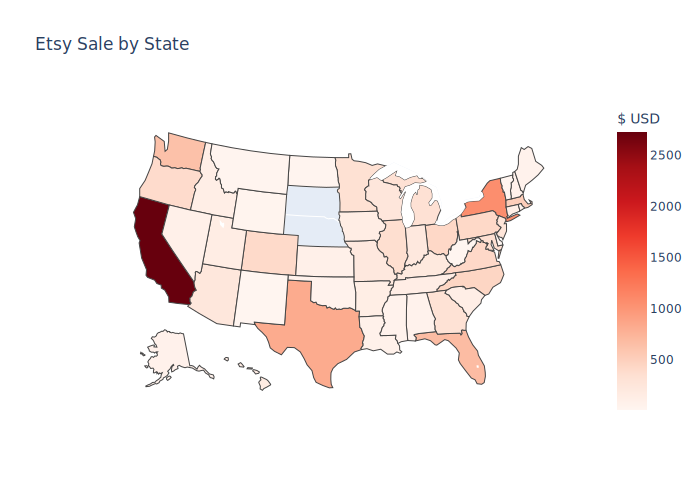

In [18]:
charts.geo_map()

geomap
